In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as tvtransforms
import torch
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import torch.nn.functional as F

In [2]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce RTX 3070


In [3]:
print(torch.__version__)

1.10.1


In [4]:
DATA_DIR = '../../CoastSat/data/blackpool/images/'

In [5]:
# x_train_dir = os.path.join(DATA_DIR, 'train')
# y_train_dir = os.path.join(DATA_DIR, 'trainannot')

# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'valannot')

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')
TRAIN_IMG_DIR = "../../CoastSat/data/blackpool/images/train/"
TRAIN_MASK_DIR = "../../CoastSat/data/blackpool/images/trainannot/"
VAL_IMG_DIR = "../../CoastSat/data/blackpool/images/val/"
VAL_MASK_DIR = "../../CoastSat/data/blackpool/images/valannot/"

In [13]:
class Dataset(BaseDataset):
    """This method creates the dataset from given directories"""
    def __init__(self, image_dir, mask_dir, transform=None):
        """initialize directories

        :image_dir: TODO
        :mask_dir: TODO
        :transform: TODO

        """
        self._image_dir = image_dir
        self._mask_dir = mask_dir
        self._transform = transform
        self.images = os.listdir(image_dir)

        self.mapping = {(0, 0, 0): 0,
                        (0, 0, 255): 1,  # 0 = class 1
                        (225, 0, 225): 2,  # 1 = class 2
                        (255, 0, 0): 3,  # 2 = class 3
                        (255, 225, 225): 4, # 3 = class 4
                        (255, 255, 0): 5}  # 4 = class 5

    def __len__(self):
        """returns length of images
        :returns: TODO

        """
        return len(self.images)
    
    def mask_to_class_rgb(self, mask):
        #print('----mask->rgb----')
        h=20
        w=722
        mask = torch.from_numpy(mask)
        mask = torch.squeeze(mask)  # remove 1

        # check the present values in the mask, 0 and 255 in my case
        #print('unique values rgb    ', torch.unique(mask)) 
        # -> unique values rgb     tensor([  0, 255], dtype=torch.uint8)

        class_mask = mask
        class_mask = class_mask.permute(2, 0, 1).contiguous()
        h, w = class_mask.shape[1], class_mask.shape[2]
        mask_out = torch.zeros(h, w, dtype=torch.long)

        for k in self.mapping:
            idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))         
            validx = (idx.sum(0) == 3)          
            mask_out[validx] = torch.tensor(self.mapping[k], dtype=torch.long)

        # check the present values after mapping, in my case 0, 1, 2, 3
        print('unique values mapped ', torch.unique(mask_out))
        # -> unique values mapped  tensor([0, 1, 2, 3])
       
        return mask_out

    def __getitem__(self, index):
        """TODO: Docstring for __getitem__.
        :returns: TODO

        """
        img_path = os.path.join(self._image_dir, self.images[index])
        mask_path = os.path.join(self._mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = self.mask_to_class_rgb(mask).cpu().detach().numpy()


        if self._transform is not None:
            augmentations = self._transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        

        return image, mask

In [7]:

def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    """TODO: Docstring for get_loaders.

    :train_dir: TODO
    :train_mask_dir: TODO
    :val_dir: TODO
    :: TODO
    :returns: TODO

    """
    train_ds = Dataset(image_dir=train_dir,
                             mask_dir=train_mask_dir,
                             transform=train_transform)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = Dataset(
        image_dir=val_dir,
        mask_dir=val_mask_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [19]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 1
EPOCHS = 5

train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
], )

val_transforms = A.Compose([
        A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
        A.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    ),
        ToTensorV2(),
    ], )
    
train_loader, val_loader = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                                           VAL_IMG_DIR, VAL_MASK_DIR,
                                           BATCH_SIZE, train_transform,
                                           val_transforms)

In [9]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16,5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


unique values mapped  tensor([1, 2, 3, 4, 5])


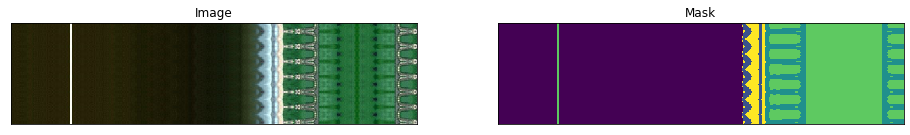

(256, 1024)
{1: 157124, 2: 5813, 3: 21662, 4: 68773, 5: 8772}
torch.Size([256, 1024, 3])


In [18]:
transforms_delete = A.Compose([
        A.PadIfNeeded(256,1024)
    ], )
dataset = Dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=transforms_delete)

image, mask = dataset[10] # get some sample
visualize(
    image=image,
    mask=mask.squeeze()
)
print(mask.shape)
unique, counts = np.unique(mask, return_counts=True)
print(dict(zip(unique, counts)))

print(torch.from_numpy(image).shape)

In [11]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['vegetation', 'ocean', 'wetsand', 'drysand', 'buildings']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.1),
])

In [13]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    #if i == 25:
    #    optimizer.param_groups[0]['lr'] = 1e-5
    #    print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/130 [00:00<?, ?it/s]unique values mapped  tensor([0, 1, 2, 3, 4])
